In [ ]:
import os
import csv
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GroupShuffleSplit
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/ML_MBD_Project/ML_MBD_TrainingSet.csv")

In [ ]:
splitter = GroupShuffleSplit(train_size=.80, test_size=.20)
split = splitter.split(train_data, groups=train_data['receiver'])
train_inds, test_inds = next(split)

train = train_data.iloc[train_inds]
test = train_data.iloc[test_inds]

In [ ]:
train_x = train.iloc[:,:-1]
train_y = train.iloc[:,-1:]
test_x = test.iloc[:,:-1]
test_y = test.iloc[:,-1:]

In [ ]:
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
test_x = test_x.to_numpy()
test_y = test_y.to_numpy()

In [ ]:
x_train = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
x_test = test_x.reshape((test_x.shape[0], test_x.shape[1], 1))

In [ ]:
num_classes = len(np.unique(train_y))

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 20
batch_size = 128

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    train_y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/20
11029/11029 [==============================] - 317s 28ms/step - loss: 1.4711 - sparse_categorical_accuracy: 0.6637 - val_loss: 1.4523 - val_sparse_categorical_accuracy: 0.6702 - lr: 0.0010
Epoch 2/20
11029/11029 [==============================] - 315s 29ms/step - loss: 1.4703 - sparse_categorical_accuracy: 0.6637 - val_loss: 1.4549 - val_sparse_categorical_accuracy: 0.6702 - lr: 0.0010
Epoch 3/20
11029/11029 [==============================] - 314s 28ms/step - loss: 1.4699 - sparse_categorical_accuracy: 0.6637 - val_loss: 1.4508 - val_sparse_categorical_accuracy: 0.6702 - lr: 0.0010
Epoch 4/20
11029/11029 [==============================] - 325s 29ms/step - loss: 1.4696 - sparse_categorical_accuracy: 0.6637 - val_loss: 1.4493 - val_sparse_categorical_accuracy: 0.6702 - lr: 0.0010
Epoch 5/20
11029/11029 [==============================] - 318s 29ms/step - loss: 1.4694 - sparse_categorical_accuracy: 0.6637 - val_loss: 1.4524 - val_sparse_categorical_accuracy: 0.6702 - lr: 0.0010


In [ ]:
loss, accuracy = model.evaluate(x_test, test_y, batch_size=128, verbose=1)
print(accuracy)

3442/3442 [==============================] - 30s 9ms/step - loss: 1.5272 - sparse_categorical_accuracy: 0.6667
0.6666969060897827


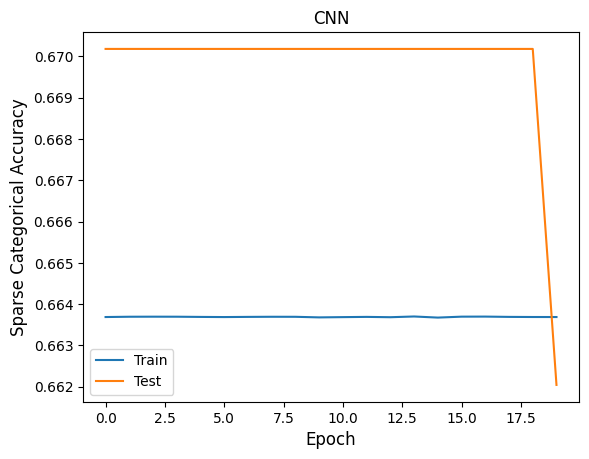

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("CNN")
plt.ylabel("Sparse Categorical Accuracy", fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["Train", "Test"], loc="best")
plt.show()
plt.close()

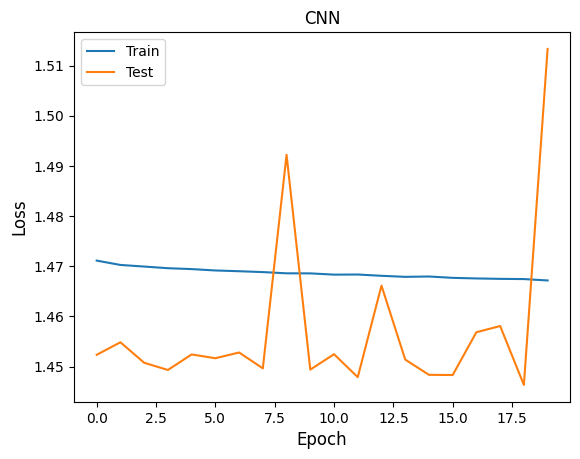

In [ ]:
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("CNN")
plt.ylabel("Loss", fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["Train", "Test"], loc="best")
plt.show()
plt.close()

In [ ]:
train_data.head()

,rcvTime,sender,messageID,receiver,posX,posY,pos_noiseX,pos_noiseY,spdX,spdY,...,spd_noiseY,aclX,aclY,acl_noiseX,acl_noiseY,hedX,hedY,hed_noiseX,hed_noiseY,label
0,27044.448149,905.0,33757073.0,909,1340.637344,1050.209731,3.600070,3.467079,-5.078127,-8.564898,...,0.005328,-1.322832,-2.231152,0.000730,0.001230,-0.536376,-0.843979,22.448294,31.813532,0
1,27044.704531,898.0,33759305.0,909,1378.408291,1091.019857,3.802718,4.035042,-7.056122,-11.901074,...,-0.004702,-0.196124,-0.330802,0.000137,0.000517,-0.612571,-0.790415,22.597318,36.683480,4
2,27044.744747,821.0,33759747.0,909,1384.658828,1213.150552,4.907842,4.692573,-1.598071,12.780995,...,0.035543,-0.011515,0.102197,0.004414,0.000110,-0.091318,0.995822,6.993068,1.660324,0
3,27045.166693,910.0,33772765.0,909,1375.874232,1114.169913,3.434970,3.519160,9.525130,-3.484410,...,-0.000000,0.000002,0.000002,0.000104,0.000104,-0.400457,-0.916316,16.731783,16.731783,8
4,27045.448140,905.0,33775101.0,909,1335.059523,1040.696089,3.573822,3.425401,-6.032388,-10.174461,...,0.006796,-0.706113,-1.191003,0.000870,0.001468,-0.536376,-0.843979,24.696326,37.369756,0


In [ ]:
train_data2 = train_data.drop(['messageID','pos_noiseX','pos_noiseY','spd_noiseX','spd_noiseY','acl_noiseX','acl_noiseY','hed_noiseX','hed_noiseY'],axis=1)
train_data2.head()

,rcvTime,sender,receiver,posX,posY,spdX,spdY,aclX,aclY,hedX,hedY,label
0,27044.448149,905.0,909,1340.637344,1050.209731,-5.078127,-8.564898,-1.322832,-2.231152,-0.536376,-0.843979,0
1,27044.704531,898.0,909,1378.408291,1091.019857,-7.056122,-11.901074,-0.196124,-0.330802,-0.612571,-0.790415,4
2,27044.744747,821.0,909,1384.658828,1213.150552,-1.598071,12.780995,-0.011515,0.102197,-0.091318,0.995822,0
3,27045.166693,910.0,909,1375.874232,1114.169913,9.525130,-3.484410,0.000002,0.000002,-0.400457,-0.916316,8
4,27045.448140,905.0,909,1335.059523,1040.696089,-6.032388,-10.174461,-0.706113,-1.191003,-0.536376,-0.843979,0


In [ ]:
splitter = GroupShuffleSplit(train_size=.80, test_size=.20)
split = splitter.split(train_data2, groups=train_data2['receiver'])
train_inds2, test_inds2 = next(split)

train2 = train_data2.iloc[train_inds2]
test2 = train_data2.iloc[test_inds2]

In [ ]:
train_x2 = train2.iloc[:,:-1]
train_y2 = train2.iloc[:,-1:]
test_x2 = test2.iloc[:,:-1]
test_y2 = test2.iloc[:,-1:]

In [ ]:
train_x2 = train_x2.to_numpy()
train_y2 = train_y2.to_numpy()
test_x2 = test_x2.to_numpy()
test_y2 = test_y2.to_numpy()

In [ ]:
x_train2 = train_x2.reshape((train_x2.shape[0], train_x2.shape[1], 1))
x_test2 = test_x2.reshape((test_x2.shape[0], test_x2.shape[1], 1))

In [ ]:
num_classes = len(np.unique(train_y2))

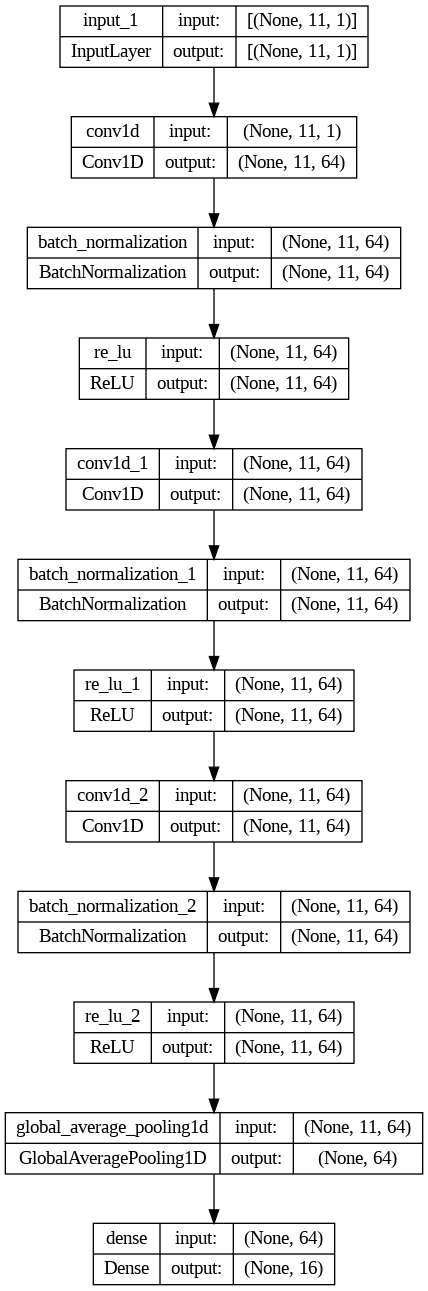

In [ ]:
model2 = make_model(input_shape=x_train2.shape[1:])
keras.utils.plot_model(model2, show_shapes=True)

In [ ]:
epochs = 20
batch_size = 128

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model2.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history2 = model2.fit(
    x_train2,
    train_y2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/20
11047/11047 [==============================] - 217s 19ms/step - loss: 1.0879 - sparse_categorical_accuracy: 0.7299 - val_loss: 1.5202 - val_sparse_categorical_accuracy: 0.6949 - lr: 0.0010
Epoch 2/20
11047/11047 [==============================] - 197s 18ms/step - loss: 0.9375 - sparse_categorical_accuracy: 0.7578 - val_loss: 1.0314 - val_sparse_categorical_accuracy: 0.7517 - lr: 0.0010
Epoch 3/20
11047/11047 [==============================] - 205s 19ms/step - loss: 0.8761 - sparse_categorical_accuracy: 0.7718 - val_loss: 1.3606 - val_sparse_categorical_accuracy: 0.6832 - lr: 0.0010
Epoch 4/20
11047/11047 [==============================] - 191s 17ms/step - loss: 0.8385 - sparse_categorical_accuracy: 0.7799 - val_loss: 1.8927 - val_sparse_categorical_accuracy: 0.3650 - lr: 0.0010
Epoch 5/20
11047/11047 [==============================] - 200s 18ms/step - loss: 0.8116 - sparse_categorical_accuracy: 0.7856 - val_loss: 1.5514 - val_sparse_categorical_accuracy: 0.6896 - lr: 0.0010


In [ ]:
loss, accuracy = model2.evaluate(x_test2, test_y2, batch_size=128, verbose=1)

3420/3420 [==============================] - 18s 5ms/step - loss: 0.9749 - sparse_categorical_accuracy: 0.7586


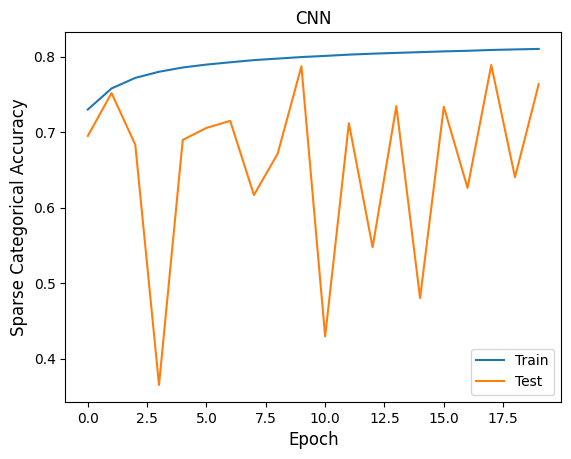

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history2.history[metric])
plt.plot(history2.history["val_" + metric])
plt.title("CNN")
plt.ylabel("Sparse Categorical Accuracy", fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["Train", "Test"], loc="best")
plt.show()
plt.close()

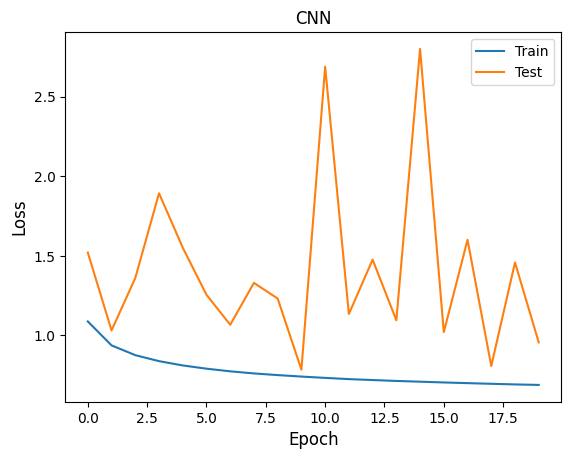

In [ ]:
metric = "loss"
plt.figure()
plt.plot(history2.history[metric])
plt.plot(history2.history["val_" + metric])
plt.title("CNN")
plt.ylabel("Loss", fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["Train", "Test"], loc="best")
plt.show()
plt.close()